<a href="https://colab.research.google.com/github/lannaelvira77/WeatherWise-LannaElvira-23486942/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise: Intelligent Weather Analysis & Advisory System

Welcome to your **WeatherWise** project notebook!



## 🧰 Setup and Imports

This section installs and imports the essential libraries used throughout the *Weather Advisor* project.
- matplotlib → for creating temperature, precipitation visualisations, etc
- pyinputplus → for building a console-style user interface with validated menu inputs.


In [95]:
!pip install matplotlib pyinputplus


In [96]:
# The plt.ion() command makes Matplotlib operate in interactive (non-blocking) mode so charts display immediately without freezing program execution.
import matplotlib.pyplot as plt
plt.ion()

## 📦 Setup and Configuration

This section configures environment variables and verifies the connection to the **OpenWeatherMap (OWM)** API.
<br> The API key is stored as an environment variable for secure access and reusability across modules.
A preliminary test request is performed to verify that the connection and credentials function correctly before further development.

### Store and Retrieve API Key

In [99]:
import os
# Set the API key as an environment variable
os.environ['OWM_API_KEY'] = "3940901d1d76b912b0cd840fd2b06ff7"

# Retrieve and store the key for later use
api_key = os.environ['OWM_API_KEY']

### Test API Connection

In [100]:
import requests

# Define test location
location = "Perth,AU"

# Build the API request URL (metric units for temperature in °C)
url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}&units=metric"

# Send the GET request to the API endpoint
response = requests.get(url)

# Convert the API response to JSON format
data = response.json()

# Display the returned JSON data to confirm successful retrieval
print("✅ API connection test completed. Response preview:")
print(data)

✅ API connection test completed. Response preview:
{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 804, 'main': 'Clouds', 'description': 'overcast clouds', 'icon': '04d'}], 'base': 'stations', 'main': {'temp': 16.75, 'feels_like': 15.97, 'temp_min': 15.58, 'temp_max': 17.24, 'pressure': 1020, 'humidity': 57, 'sea_level': 1020, 'grnd_level': 1017}, 'visibility': 10000, 'wind': {'speed': 5.14, 'deg': 170}, 'rain': {'1h': 0.1}, 'clouds': {'all': 100}, 'dt': 1759640887, 'sys': {'type': 2, 'id': 63154, 'country': 'AU', 'sunrise': 1759614565, 'sunset': 1759659640}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


## 🌤️ Weather Data Functions

This section defines all functions responsible for retrieving, processing, and preparing weather data from the **OpenWeatherMap (OWM)** API.
<BR> It includes network request handling, caching, data aggregation, and error management to ensure consistent and efficient access to current and forecast information. The resulting data structures are used by the user interface, natural-language module, and visualisation components of the application.

Core tasks performed in this section:
- Establish API requests for current and 5-day forecasts.
- Implement lightweight caching to reduce repeated calls.
- Handle API errors and invalid inputs gracefully.
- Aggregate 3-hour forecast data into daily summaries.
- Provide helper functions (_safe_get, _make_error, etc.) for cleaner and safer data access.

### Imports, constants, and small utility functions

In [77]:
import os, requests
from datetime import datetime, timezone
from collections import defaultdict
import time

_WEATHER_CACHE = {}
_CACHE_TTL_SECONDS = 600  # 10 minutes
_RETRY_STATUS = {502, 503, 504}  # transient
_DEFAULT_TIMEOUT = 20

def _now_utc():
    return datetime.now(timezone.utc)

def _make_error(message, code=None, hint=None):
    """Standard error payload the UI can render."""
    return {"error": {"message": message, "code": code, "hint": hint}}

def _safe_get(d, path, default=None):
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return default
        cur = cur[p]
    return cur

from datetime import datetime, timedelta
from collections import defaultdict

def _aggregate_daily_from_3h(forecast_json, forecast_days, tz_offset=0):
    """Group 3-hourly forecast entries by local date using the timezone offset."""
    three_hour_list = forecast_json.get("list", [])
    buckets = defaultdict(list)

    for item in three_hour_list:
        dt_txt = item.get("dt_txt")
        if not dt_txt:
            continue
        try:
            # Convert UTC timestamp → local time (offset in seconds)
            dt_obj = datetime.strptime(dt_txt, "%Y-%m-%d %H:%M:%S")
            local_dt = dt_obj + timedelta(seconds=tz_offset)
            day = local_dt.strftime("%Y-%m-%d")
        except Exception:
            # fallback to UTC date if anything goes wrong
            day = dt_txt.split(" ")[0]
        buckets[day].append(item)

    daily_rows = []
    for day in sorted(buckets.keys()):
        rows = buckets[day]
        temps = [_safe_get(x, ["main","temp"]) for x in rows if _safe_get(x, ["main","temp"]) is not None]
        pops  = [x.get("pop") for x in rows if isinstance(x.get("pop"), (int, float))]
        descs = [_safe_get(x, ["weather"], [{}])[0].get("description") for x in rows if _safe_get(x, ["weather"], [{}])]
        icons = [_safe_get(x, ["weather"], [{}])[0].get("icon") for x in rows if _safe_get(x, ["weather"], [{}])]
        if not temps:
            continue
        temp_min, temp_max = min(temps), max(temps)
        temp_avg = sum(temps) / len(temps)
        pop_avg = (sum(pops) / len(pops) * 100.0) if pops else 0.0

        def _most_common(lst):
            if not lst: return None
            c = {}
            for v in lst: c[v] = c.get(v, 0) + 1
            return max(c, key=c.get)

        description = (_most_common([d for d in descs if d]) or (descs[0] if descs else "") or "").capitalize()
        icon = _most_common([i for i in icons if i]) or (icons[0] if icons else "")

        daily_rows.append({
            "date": day,
            "temp_min": round(temp_min, 2),
            "temp_max": round(temp_max, 2),
            "temp_avg": round(temp_avg, 2),
            "pop": round(pop_avg, 1),
            "description": description,
            "icon": icon
        })
    return daily_rows[:max(1, min(int(forecast_days), 5))]

def _http_get_with_retry(url, params, timeout=_DEFAULT_TIMEOUT, retries=1):
    """Tiny retry for transient 5xx."""
    for attempt in range(retries + 1):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            return r
        except requests.exceptions.RequestException as e:
            if attempt >= retries:
                raise
            time.sleep(0.8)  # backoff
    # unreachable
    return None

def get_weather_data(location, forecast_days=5, include_hourly_24h=True, use_cache=True):
    """
    Retrieve weather data (OpenWeatherMap v2.5) and return a hybrid-friendly dict.

    Returns either a data dict or {"error": {...}} for the UI to render nicely.
    """
    # ---- Input validation ----
    if not isinstance(location, str) or not location.strip():
        return _make_error("Please provide a city name (e.g., 'Perth,AU').", code="bad_input")
    location = location.strip()
    try:
        forecast_days = int(forecast_days)
    except Exception:
        return _make_error("forecast_days must be an integer between 1 and 5.", code="bad_input")
    if not (1 <= forecast_days <= 5):
        return _make_error("forecast_days must be between 1 and 5.", code="bad_input")

    api_key = os.environ.get("OWM_API_KEY")
    if not api_key:
        return _make_error("Missing API key. Set OWM_API_KEY.", code="missing_api_key",
                           hint="In Colab: os.environ['OWM_API_KEY'] = '...your key...'")

    base_url_current = "https://api.openweathermap.org/data/2.5/weather"
    base_url_forecast = "https://api.openweathermap.org/data/2.5/forecast"
    params = {"q": location, "appid": api_key, "units": "metric"}

    # ---- Cache ----
    cache_key = (location.lower(), forecast_days)
    if use_cache and cache_key in _WEATHER_CACHE:
        cached = _WEATHER_CACHE[cache_key]
        if (_now_utc() - cached["fetched_at"]).total_seconds() < _CACHE_TTL_SECONDS:
            return cached["data"]

    # ---- API calls with graceful errors ----
    try:
        cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code in _RETRY_STATUS:
            cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code == 401:
            return _make_error("Invalid API key (401). Check OWM_API_KEY.", code=401)
        if cur_res.status_code == 404:
            return _make_error(f"City not found: '{location}'.", code=404,
                               hint="Try 'City,CountryCode' e.g., 'Perth,AU'.")
        if cur_res.status_code == 429:
            return _make_error("Rate limit exceeded (429). Please try again shortly.", code=429)
        cur_res.raise_for_status()

        fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        if fct_res.status_code in _RETRY_STATUS:
            fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        fct_res.raise_for_status()

    except requests.exceptions.Timeout:
        return _make_error("The weather service timed out. Please try again.", code="timeout")
    except requests.exceptions.RequestException as e:
        return _make_error(f"Network error: {e}", code="network")

    # ---- Parse JSON, handle provider-level errors ----
    cur_json = cur_res.json()
    fct_json = fct_res.json()

    # Sometimes OWM returns {"cod":"404", ...} even with 200 HTTP
    cod = cur_json.get("cod")
    if str(cod) != "200":
        return _make_error(cur_json.get("message", "Unknown error from provider."), code=cod)

    fetched_at = _now_utc().isoformat()
    loc_name = cur_json.get("name", location)
    loc_country = _safe_get(cur_json, ["sys","country"], "")
    lat = _safe_get(cur_json, ["coord","lat"])
    lon = _safe_get(cur_json, ["coord","lon"])
    tz_seconds = _safe_get(cur_json, ["timezone"], 0)

    weather0 = _safe_get(cur_json, ["weather"], [{}])[0] or {}
    current = {
        "temp": round(_safe_get(cur_json, ["main","temp"], 0.0), 2),
        "description": weather0.get("description", "").capitalize(),
        "humidity": _safe_get(cur_json, ["main","humidity"], 0),
        "wind_speed": _safe_get(cur_json, ["wind","speed"], 0.0),
        "icon": weather0.get("icon", ""),
        "sunrise": _safe_get(cur_json, ["sys","sunrise"]),
        "sunset": _safe_get(cur_json, ["sys","sunset"]),
    }
    current["summary"] = f"{current['temp']}°C, {current['description']} (Humidity {current['humidity']}%, Wind {current['wind_speed']} m/s)"

    daily = _aggregate_daily_from_3h(fct_json, forecast_days, tz_offset=tz_seconds)

    hourly_24h = None
    if include_hourly_24h:
        slots = (fct_json.get("list") or [])[:8]
        hourly_24h = []
        for it in slots:
            w0 = _safe_get(it, ["weather"], [{}])[0] or {}
            hourly_24h.append({
                "dt": it.get("dt_txt"),
                "temp": round(_safe_get(it, ["main","temp"], 0.0), 2),
                "pop": round((it.get("pop") or 0) * 100.0, 1),
                "description": (w0.get("description") or "").capitalize(),
                "icon": w0.get("icon", "")
            })

    data = {
        "meta": {"provider": "OpenWeatherMap", "fetched_at_utc": fetched_at, "units": "metric"},
        "location": {"query": location, "name": loc_name, "country": loc_country, "lat": lat, "lon": lon,
                     "timezone_offset_seconds": tz_seconds},
        "current": current,
        "daily": daily,
    }
    if hourly_24h is not None:
        data["hourly_24h"] = hourly_24h

    if use_cache:
        _WEATHER_CACHE[cache_key] = {"data": data, "fetched_at": _now_utc()}

    return data

# Optional helpers for your UI/tests
def weather_cache_info():
    return {"entries": len(_WEATHER_CACHE), "ttl_seconds": _CACHE_TTL_SECONDS}

def weather_cache_clear():
    _WEATHER_CACHE.clear()


#Test The Functions
import json

# Happy path
ok = get_weather_data("Perth,AU", 3)
print(json.dumps(ok, indent=2)[:600], "...")

# Bad city
bad = get_weather_data("NoSuchCityZZ,AU", 3)
print(bad)

# Bad forecast_days
bad_days = get_weather_data("Perth,AU", 9)
print(bad_days)

{
  "meta": {
    "provider": "OpenWeatherMap",
    "fetched_at_utc": "2025-10-05T04:41:01.440664+00:00",
    "units": "metric"
  },
  "location": {
    "query": "Perth,AU",
    "name": "Perth",
    "country": "AU",
    "lat": -31.9333,
    "lon": 115.8333,
    "timezone_offset_seconds": 28800
  },
  "current": {
    "temp": 16.43,
    "description": "Light rain",
    "humidity": 57,
    "wind_speed": 4.12,
    "icon": "10d",
    "sunrise": 1759614565,
    "sunset": 1759659640,
    "summary": "16.43\u00b0C, Light rain (Humidity 57%, Wind 4.12 m/s)"
  },
  "daily": [
    {
      "date": "2025-1 ...
{'error': {'message': "City not found: 'NoSuchCityZZ,AU'.", 'code': 404, 'hint': "Try 'City,CountryCode' e.g., 'Perth,AU'."}}
{'error': {'message': 'forecast_days must be between 1 and 5.', 'code': 'bad_input', 'hint': None}}


## Shared Validators & Data Helpers

In [79]:
# ===== Extensions: Shared helpers =====
import re
from datetime import datetime, timedelta, timezone

def validate_location_format(loc: str) -> tuple[bool, str | None]:
    """
    Basic sanity check for 'City' or 'City,CC' (CC=country code).
    We keep it permissive; API will still be the source of truth.
    """
    if not isinstance(loc, str) or not loc.strip():
        return False, "Please enter a non-empty city name (e.g., 'Perth,AU')."
    loc = loc.strip()
    if len(loc) < 2:
        return False, "City name seems too short."
    # Allow letters, spaces, hyphens, dots, apostrophes, comma + 2-letter CC
    if not re.match(r"^[A-Za-z .'\-]+(,\s*[A-Za-z]{2})?$", loc):
        return True, "Note: unusual city format; attempting lookup anyway."
    return True, None

def daterange(start_date: datetime, days: int):
    for i in range(days):
        yield start_date + timedelta(days=i)

# ===== Extensions: Activity recommendation (e.g., hiking) =====
def score_hiking_day(day: dict) -> tuple[int, list[str]]:
    """
    Score a day (0-100) for hiking using simple heuristics:
      - Too hot/cold reduces score
      - Rain chance reduces score
      - Moderate wind is fine; very windy reduces
    """
    reasons = []
    score = 100

    t_avg = day.get("temp_avg")
    t_min = day.get("temp_min")
    t_max = day.get("temp_max")
    pop   = day.get("pop", 0.0)           # %
    # Wind not available per-day in free OWM feed—leave note
    windy = None

    # Temperature comfort band
    if t_avg is not None:
        if t_avg < 5:   score -= 35; reasons.append("very cold")
        elif t_avg < 12: score -= 15; reasons.append("cool")
        elif t_avg > 35: score -= 30; reasons.append("extreme heat")
        elif t_avg > 30: score -= 15; reasons.append("hot")

    # Precipitation
    if pop >= 70: score -= 40; reasons.append("high rain chance")
    elif pop >= 40: score -= 20; reasons.append("possible showers")

    # Wind (not daily here). If you later add daily wind, apply it:
    # if wind_speed and wind_speed > 10: score -= 15; reasons.append("windy")

    # Clamp
    score = max(0, min(100, score))
    return score, reasons

def recommend_activity(weather_data: dict, activity: str = "hiking", days: int | None = None) -> str:
    """
    Return a short human-readable recommendation summary for the next N days.
    For now only 'hiking' has scoring logic; easily extended for others.
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return "I can't assess activities right now due to missing weather data."

    daily = weather_data.get("daily") or []
    if not daily:
        return "No multi-day forecast available to make a recommendation."

    k = max(1, min(days or len(daily), len(daily)))
    daily = daily[:k]

    if activity.lower() != "hiking":
        return f"I don't have a model for {activity} yet—try 'hiking'."

    lines = []
    best = None
    for d in daily:
        score, reasons = score_hiking_day(d)
        tag = "✅ Good" if score >= 75 else ("⚠️ Fair" if score >= 50 else "❌ Poor")
        reason_txt = (", ".join(reasons) if reasons else "conditions look fine")
        lines.append(f"{d['date']}: {tag} ({score}/100) — {reason_txt}")
        best = max(best or (score, d['date']), (score, d['date']))

    summary = f"Recommendation for hiking in {weather_data['location']['name']} (next {k} days):\n" + "\n".join("- " + x for x in lines)
    if best:
        summary += f"\n\nBest day: {best[1]} (score {best[0]}/100)."
    return summary

## 📊 Visualisation Functions

In [80]:
# ---- Visualisation theme helpers ----
DEFAULT_THEME = {
    "temp_line": "orange",
    "hourly_line": "orange",
    "rain_bar": "skyblue",
    "tmin_line": "blue",
    "tmax_line": "red",
    "bar_edge": "black",
    "grid_alpha": 0.6,
}

def apply_theme_color(theme: dict | None, key: str, fallback: str | None = None):
    """Return themed color if provided, otherwise the fallback."""
    if isinstance(theme, dict) and key in theme:
        return theme[key]
    return fallback

### Temperature Trend Visualisation

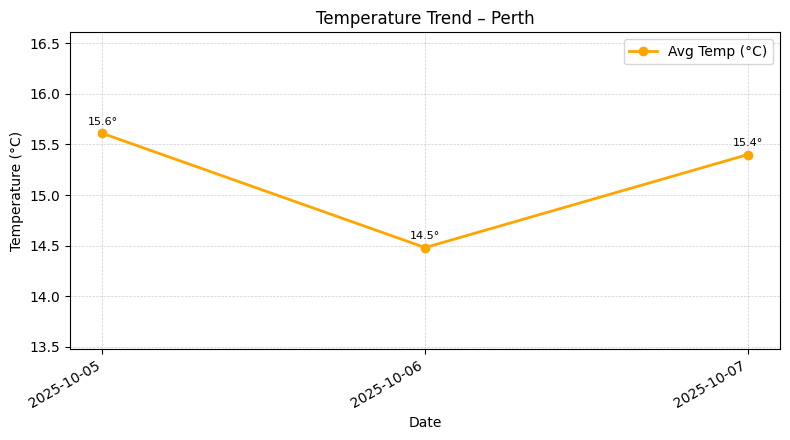

In [81]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation of the temperature trend over the forecast period.
    Line chart of daily average temperature with labels, legend, and guards.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure (preferred):
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_avg":float,"temp_min":float,"temp_max":float, ...}, ...
                ]
            Fallback (simpler schema):
                weather_data["forecast"] = [
                    {"date":"YYYY-MM-DD","temp":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    # ---- Guards ----
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    # Prefer enhanced schema
    daily = weather_data.get("daily") or []
    dates, temps = [], []
    if daily:
        for row in daily:
            d = row.get("date")
            t = row.get("temp_avg", row.get("temp"))
            if d is None or t is None:
                continue
            dates.append(d)
            temps.append(float(t))
    else:
        # Fallback simple schema
        for row in weather_data.get("forecast", []):
            d, t = row.get("date"), row.get("temp")
            if d is None or t is None:
                continue
            dates.append(d); temps.append(float(t))

    if not dates or not temps:
        print("ℹ️ No temperature data available.")
        return None

    # Ensure chronological order
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), t) for d, t in zip(dates, temps)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        temps = [t for _, t in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    color = apply_theme_color(theme, "temp_line", "orange")
    ax.plot(dates, temps, marker='o', linewidth=2, color=color, label="Avg Temp (°C)")
    ax.set_title(f"Temperature Trend – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    # Annotate points
    for x, y in zip(dates, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    # Y padding for extremes
    ymin, ymax = min(temps), max(temps)
    if ymin == ymax:
        ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    if output_type == 'figure':
        return fig

    # --- Non-blocking show ---
    try:
        plt.show(block=False)
        plt.pause(0.001)  # let it render briefly
    except Exception:
        pass

    # Do NOT close the figure here — keep it open for viewing
    return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_temperature_visualisation(data)                 # displays chart

### Precipitation Probability Visualisation



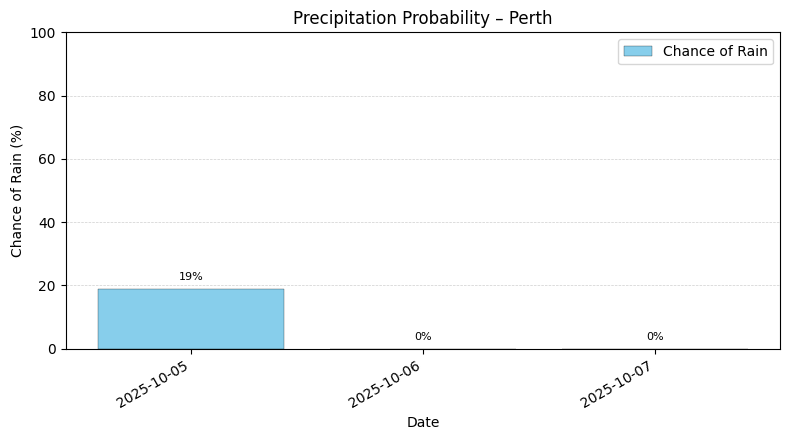

In [82]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_precipitation_visualisation(weather_data, output_type='display', theme=None):
    """
    Bar chart of daily precipitation probability (POP).
    Expects weather_data['daily'][i] to have keys: 'date' (YYYY-MM-DD) and 'pop' (0..100).
    Falls back to a simple heuristic if only textual 'description' exists.
    """
    # ---- Guards ----
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    def _theme(key, default):
        # Safe wrapper in case apply_theme_color isn't available
        try:
            return apply_theme_color(theme, key, default)
        except Exception:
            return default

    title_location = (
        weather_data.get("location", {}).get("name")
        or weather_data.get("location", "")
        or "Selected Location"
    )

    # ---- Collect data ----
    dates, pops = [], []
    daily = weather_data.get("daily") or []
    if daily:
        for row in daily:
            d, p = row.get("date"), row.get("pop")
            if d is None or p is None:
                continue
            dates.append(d)
            pops.append(float(p))
    else:
        # Fallback: derive a rough probability from description text
        for row in weather_data.get("forecast", []):
            d = row.get("date")
            desc = (row.get("description") or "").lower()
            if not d:
                continue
            if any(w in desc for w in ("rain", "shower", "storm")):
                prob = 60.0
            elif "cloud" in desc:
                prob = 30.0
            else:
                prob = 10.0
            dates.append(d)
            pops.append(prob)

    if not dates or not pops:
        print("ℹ️ No precipitation data available for this period.")
        return None

    # ---- Sort chronologically (best effort) ----
    try:
        pairs = sorted(
            [(datetime.strptime(d, "%Y-%m-%d"), p) for d, p in zip(dates, pops)],
            key=lambda x: x[0]
        )
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        pops  = [p for _, p in pairs]
    except Exception:
        pass

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(
        dates,
        pops,
        label="Chance of Rain",
        color=_theme("rain_bar", "skyblue"),
        edgecolor=_theme("bar_edge", "black"),
        linewidth=0.2,
    )
    ax.set_title(f"Precipitation Probability – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=_theme("grid_alpha", 0.6))
    ax.legend(loc="best")

    for i, v in enumerate(pops):
        ax.text(i, min(v + 2, 100), f"{v:.0f}%", ha='center', va='bottom', fontsize=8)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()

    if output_type == 'figure':
        return fig

    # ---- Non-blocking show so your chat input returns immediately ----
    try:
        plt.show(block=False)
        plt.pause(0.001)  # let the GUI event loop draw
    except Exception:
        pass

    # Do NOT close here; keep the window open
    return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_precipitation_visualisation(data)

### Temperature Range Visualisation

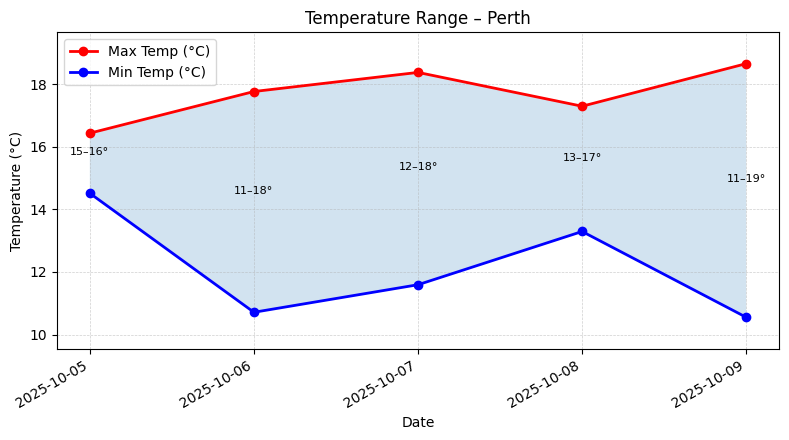

In [83]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_range_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation showing the daily minimum and maximum temperatures
    over the forecast period, with a shaded range area.
    Dual-line (min & max) with shaded range; robust to single-day data.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_min":float,"temp_max":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"
    daily = weather_data.get("daily") or []
    dates, tmin, tmax = [], [], []
    for row in daily:
        d, lo, hi = row.get("date"), row.get("temp_min"), row.get("temp_max")
        if d is None or lo is None or hi is None:
            continue
        dates.append(d); tmin.append(float(lo)); tmax.append(float(hi))

    if not dates:
        print("ℹ️ No temperature range data available.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), lo, hi) for d, lo, hi in zip(dates, tmin, tmax)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _, _ in pairs]
        tmin  = [lo for _, lo, _ in pairs]
        tmax  = [hi for _, _, hi in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    c_max = apply_theme_color(theme, "tmax_line", "red")
    c_min = apply_theme_color(theme, "tmin_line", "blue")
    ax.plot(dates, tmax, marker='o', label="Max Temp (°C)", color=c_max, linewidth=2)
    ax.plot(dates, tmin, marker='o', label="Min Temp (°C)", color=c_min, linewidth=2)

    # Shaded band (only if ≥2 points; otherwise fill_between can look odd)
    if len(dates) >= 2:
        ax.fill_between(dates, tmin, tmax, alpha=0.2)

    ax.set_title(f"Temperature Range – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    # Midpoint annotations
    for x, lo, hi in zip(dates, tmin, tmax):
        mid = (lo + hi) / 2
        ax.annotate(f"{lo:.0f}–{hi:.0f}°", xy=(x, mid), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(tmin + tmax), max(tmin + tmax)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure':
        return fig

    # ---- Non-blocking show so your chat input returns immediately ----
    try:
        plt.show(block=False)
        plt.pause(0.001)  # let the GUI event loop draw
    except Exception:
        pass

    # Do NOT close here; keep the window open
    return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=5)
create_temperature_range_visualisation(data)

### Wind Speed and Humidity Visualisation

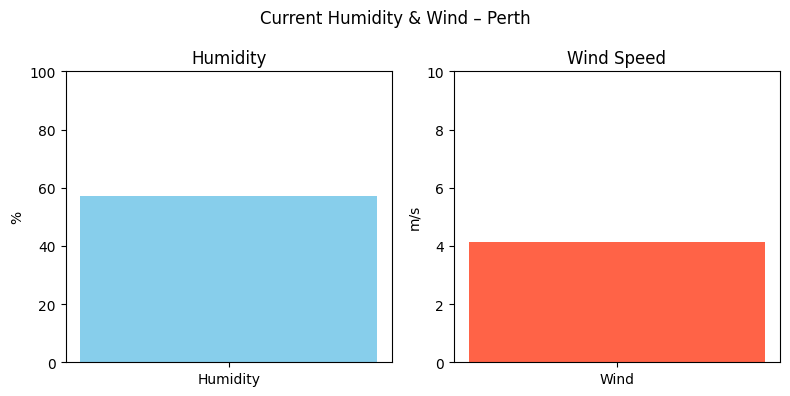

In [84]:
def create_wind_humidity_visualisation(weather_data, output_type='display', theme=None):
    if not weather_data or "current" not in weather_data:
        print("⚠️ Invalid data.")
        return None

    loc = weather_data["location"]["name"]
    cur = weather_data["current"]
    humidity = cur.get("humidity", 0)
    wind = cur.get("wind_speed", 0)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Humidity
    axs[0].bar(["Humidity"], [humidity], color="skyblue")
    axs[0].set_ylim(0, 100)
    axs[0].set_ylabel("%")
    axs[0].set_title("Humidity")

    # Wind Speed
    axs[1].bar(["Wind"], [wind], color="tomato")
    axs[1].set_ylim(0, max(10, wind + 2))
    axs[1].set_ylabel("m/s")
    axs[1].set_title("Wind Speed")

    fig.suptitle(f"Current Humidity & Wind – {loc}")
    plt.tight_layout()
    if output_type == 'figure':
        return fig

    # ---- Non-blocking show so your chat input returns immediately ----
    try:
        plt.show(block=False)
        plt.pause(0.001)  # let the GUI event loop draw
    except Exception:
        pass

    # Do NOT close here; keep the window open
    return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_wind_humidity_visualisation(data)

## 🤖 Natural Language Processing

In [85]:
import re
from datetime import datetime, timezone, timedelta

def _try_parse_date_to_iso(s: str) -> str | None:
    s = s.strip()
    # ISO and D/M/Y
    for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date().isoformat()
        except Exception:
            pass
    # D Month Y (8 October 2025)
    month_names = ("jan|january|feb|february|mar|march|apr|april|may|jun|june|jul|july|aug|august|"
                   "sep|september|oct|october|nov|november|dec|december")
    m = re.search(rf"\b(\d{{1,2}})\s+({month_names})\s+(\d{{4}})\b", s, flags=re.I)
    if m:
        d, mon, y = m.group(1), m.group(2).lower(), int(m.group(3))
        mm = {'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,'may':5,
              'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'september':9,
              'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12}[mon]
        try: return datetime(y, mm, int(d)).date().isoformat()
        except Exception: return None
    # Month D, Y (Oct 8, 2025)
    m = re.search(rf"\b({month_names})\s+(\d{{1,2}})(?:st|nd|rd|th)?(?:,)?\s+(\d{{4}})\b", s, flags=re.I)
    if m:
        mon, d, y = m.group(1).lower(), int(m.group(2)), int(m.group(3))
        mm = {'jan':1,'january':1,'feb':2,'february':2,'mar':3,'march':3,'apr':4,'april':4,'may':5,
              'jun':6,'june':6,'jul':7,'july':7,'aug':8,'august':8,'sep':9,'september':9,
              'oct':10,'october':10,'nov':11,'november':11,'dec':12,'december':12}[mon]
        try: return datetime(y, mm, d).date().isoformat()
        except Exception: return None
    return None

def _extract_explicit_date(q_raw: str) -> str | None:
    # ISO first
    m = re.search(r"\b(20\d{2}-\d{1,2}-\d{1,2})\b", q_raw)
    if m:
        return _try_parse_date_to_iso(m.group(1))
    # D/M/Y
    m = re.search(r"\b(\d{1,2}/\d{1,2}/20\d{2})\b", q_raw)
    if m:
        return _try_parse_date_to_iso(m.group(1))
    # Month name variants
    return _try_parse_date_to_iso(q_raw)

# --- Robust location extractor that is date-aware ---
def _extract_location(s: str) -> str | None:
    """
    Extract a plausible location while ignoring explicit dates, time phrases,
    and activity nouns like 'picnic' or 'hiking'.
    """
    if not isinstance(s, str) or not s.strip():
        return None

    text = s.strip()

    # ---- strip explicit dates to avoid confusing the parser ----
    month_names = ("jan|january|feb|february|mar|march|apr|april|may|jun|june|jul|july|aug|august|"
                   "sep|september|oct|october|nov|november|dec|december")
    date_pattern = rf"""
        (?:\b20\d{{2}}-\d{{1,2}}-\d{{1,2}}\b)                          # 2025-10-08
        |
        (?:\b\d{{1,2}}/\d{{1,2}}/20\d{{2}}\b)                           # 8/10/2025
        |
        (?:\b\d{{1,2}}\s+(?:{month_names})\s+\d{{4}}\b)                 # 8 October 2025
        |
        (?:\b(?:{month_names})\s+\d{{1,2}}(?:st|nd|rd|th)?(?:,)?\s+\d{{4}}\b)  # Oct 8, 2025
    """
    text = re.sub(date_pattern, " ", text, flags=re.I | re.VERBOSE)

    # ---- time-phrase guard ----
    time_phrase = re.compile(
        r"""^(
            (?:the\s+)?next\s+\d+\s*(?:day|days)\b |
            next\s+few\s+days\b |
            today\b | tomorrow\b | tonight\b |
            this\s+(?:week|weekend|morning|afternoon|evening)\b
        )""",
        flags=re.I | re.X
    )

    # Common non-location words to reject
    STOP_LEAD = {
        "what", "whats", "what’s", "will", "is", "are", "do", "does", "should", "can", "could",
        "show", "give", "tell", "temperature", "temp", "weather", "forecast", "rain", "hourly",
        "please", "display", "chart", "graph", "next", "this", "today", "tomorrow"
    }

    # Activity words that are NOT locations
    ACTIVITY_WORDS = {
        "hike", "hiking", "picnic", "beach", "swim", "swimming", "surf", "surfing"
    }

    # Trailing time words to strip from a captured candidate
    TRAILING_TIME = re.compile(
        r"""(\s*,?\s*)\b(
            today|tomorrow|tonight|
            this\s+(?:week|weekend|morning|afternoon|evening)
        )\b.*$""",
        flags=re.I | re.X
    )

    def clean_candidate(cand: str) -> str:
        cand = cand.strip()
        cand = re.sub(r"[?!\.;,:]+$", "", cand).strip()
        cand = TRAILING_TIME.sub("", cand).strip()  # <— strip trailing time words
        cand = re.sub(r"\s+", " ", cand)
        return cand

    def is_valid_place_token(tok: str) -> bool:
        t = tok.strip().lower()
        if t in STOP_LEAD: return False
        if t in ACTIVITY_WORDS: return False  # <— reject activities as locations
        if time_phrase.match(tok): return False
        return True

    candidates = []

    # ---- Prefer 'in/at/near/around <Location>' (take the last occurrence) ----
    # NOTE: deliberately EXCLUDE 'for' to avoid 'for picnic today'
    for prep in ("in", "at", "near", "around"):
        pat = re.compile(rf"\b{prep}\s+([A-Za-z][A-Za-z\.\-'\s]{{0,60}}(?:,\s*[A-Za-z]{{2,3}})?)", re.I)
        for m in pat.finditer(text):
            cand = clean_candidate(m.group(1))
            if not cand:
                continue
            head = cand.split()[0]
            if len(cand) >= 3 and is_valid_place_token(head):
                # Extra guard: ignore 'the next ...'
                if not re.match(r"^(the\s+)?next\b", cand, flags=re.I):
                    candidates.append((prep, cand))

    # If we found any candidates, prefer the last 'in', otherwise last candidate
    if candidates:
        last_in = [c for p, c in candidates if p == "in"]
        if last_in:
            return last_in[-1]
        return candidates[-1][1]

    # If no prepositional form found, return None and let caller use default.
    return None

def parse_weather_question(question: str) -> dict:
    """
    Parse a natural language weather question into structured intent.

    Returns:
      {
        "attribute": "temperature" | "rain" | "wind" | "humidity" | "conditions",
        "time_period": "today" | "tomorrow" | "next_n_days" | "specific_date",
        "n": <int or None>,
        "forecast_days": <int 1..5>,
        "location": <str or None>,
        "target_date": <YYYY-MM-DD or None>,
        "question_type": "yesno" | "value" | "summary",
        "raw": <original question>
      }
    """
    import re
    if not isinstance(question, str) or not question.strip():
        return {"error": "Empty question.", "raw": question}

    q_raw = question.strip()
    q = q_raw.lower()

    # ---- attribute detection ----
    if re.search(r"\b(temp|temperature|hot|cold|warm|cool)\b", q):
        attr = "temperature"
    elif re.search(r"\b(rain|raining|rainy|shower|showers|precip|precipitation|umbrella|wet)\b", q):
        attr = "rain"
    elif re.search(r"\b(wind|windy|gust|gusts)\b", q):
        attr = "wind"
    elif re.search(r"\b(humidity|humid)\b", q):
        attr = "humidity"
    elif re.search(r"\b(weather|forecast|clear|cloud|cloudy|sunny|storm|snow|overcast)\b", q):
        attr = "conditions"
    else:
        attr = "conditions"

    # ---- explicit date BEFORE relative time ----
    target_iso = _extract_explicit_date(q_raw)  # YYYY-MM-DD or None
    time_period, n_days = None, None
    if target_iso:
        time_period = "specific_date"
    else:
        if re.search(r"\btoday\b", q):
            time_period = "today"
        elif re.search(r"\btomorrow\b", q):
            time_period = "tomorrow"
        else:
            m = re.search(r"\bnext\s+(\d+)\s*(day|days)\b", q)
            if m:
                n_days = max(1, min(int(m.group(1)), 5))
                time_period = "next_n_days"
            elif re.search(r"\bnext\s+few\s+days\b", q):
                n_days = 3
                time_period = "next_n_days"
            elif re.search(r"\bthis\s+week(end)?\b", q):
                n_days = 3
                time_period = "next_n_days"

    if not time_period:
        time_period = "today"

    # ---- forecast_days ----
    if time_period == "today":
        forecast_days = 1
    elif time_period == "tomorrow":
        forecast_days = 2
    elif time_period == "next_n_days":
        forecast_days = max(1, min(int(n_days or 3), 5))
    elif time_period == "specific_date":
        forecast_days = 5   # maximize chance target date is inside horizon
    else:
        forecast_days = 3
    forecast_days = max(1, min(int(forecast_days), 5))

    # ---- question type ----
    if re.match(r"\s*(will|is|are|do|does|should|can|could)\b", q):
        question_type = "yesno"
    elif re.search(r"\bforecast|weather\b", q) and attr == "conditions":
        question_type = "summary"
    else:
        question_type = "value"

    # ---- location extraction (stops before 'on <date>') ----
    loc = _extract_location(q_raw)
    if loc:
        loc = re.sub(r"\s+", " ", loc)

    return {
        "attribute": attr,
        "time_period": time_period,
        "n": n_days,
        "forecast_days": forecast_days,
        "location": loc,
        "target_date": target_iso,   # <— used for specific_date
        "question_type": question_type,
        "raw": q_raw
    }

In [86]:
# Activity-aware parser (wrapper)

def parse_weather_question_with_activities(question: str) -> dict:
    """
    Wrapper around parse_weather_question() that also detects activity intent,
    e.g. 'hiking'. If hiking is detected, ensures at least 3 forecast days so
    we can compare days for a recommendation.
    """
    # Use your existing base parser first
    base = parse_weather_question(question)
    if not isinstance(base, dict) or "error" in base:
        return base

    q = (question or "").lower()

    # ---- Detect activities (you can add more later) ----
    activity = None
    # Hiking
    if re.search(r"\b(hik(e|ing))\b", q) or re.search(r"\bgood\s+for\s+hiking\b", q):
        activity = "hiking"
    # Other activities we "recognise" but don't support yet
    elif re.search(r"\b(picnic|beach|swim|swimming|surf(ing)?)\b", q):
        # we set the activity so the responder can say it's unsupported
        activity = "unsupported_activity"


    # You can add more activities here (beach, picnic, etc.), but only 'hiking'
    # is implemented in recommend_activity() for now.

    if activity:
        base["activity"] = activity
        # Make sure we fetch enough days to compare (min 3, max 5)
        fd = base.get("forecast_days", 3)
        base["forecast_days"] = max(3, min(5, int(fd or 3)))

        # If user asked "tomorrow good for hiking", keep time_period but still fetch ≥3
        # The recommender will still show a multi-day comparison.
    return base

In [87]:
def generate_weather_response(parsed_question: dict, weather_data: dict) -> str:
    """
    Turn parsed intent + fetched weather_data into a natural-language reply.

    Handles:
      - attribute phrasing (temperature, rain, wind, humidity, conditions)
      - time periods (today, tomorrow, next_n_days, specific_date) using the *location's* local date
      - graceful fallbacks when data is missing
    """
    # ---- guard rails ----
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."

    # provider/UI error passthrough
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    from datetime import datetime, timezone, timedelta

    attr   = (parsed_question.get("attribute") or "conditions").lower()
    period = parsed_question.get("time_period") or "today"
    n_days = parsed_question.get("n")
    qtype  = parsed_question.get("question_type", "value")

    loc_name  = weather_data.get("location", {}).get("name") or weather_data.get("location") or "the selected location"
    tz_seconds = weather_data.get("location", {}).get("timezone_offset_seconds", 0)

    current = weather_data.get("current") or {}
    daily   = weather_data.get("daily")  or []

    # ---- helpers ----
    def fmt_deg(v):
        try:
            return f"{float(v):.1f}°C"
        except:
            return "N/A"

    def fmt_pct(v):
        try:
            return f"{float(v):.0f}%"
        except:
            return "N/A"

    # ---- compute local 'today' and pick indices for today/tomorrow in daily[] ----
    local_now = datetime.now(timezone.utc) + timedelta(seconds=tz_seconds)
    local_today_str = local_now.date().strftime("%Y-%m-%d")

    idx_today = None
    idx_tomorrow = None

    if daily:
        try:
            daily = sorted(daily, key=lambda d: d.get("date", "9999-12-31"))
        except Exception:
            pass

        for i, drow in enumerate(daily):
            ddate = drow.get("date")
            if not ddate:
                continue
            if ddate == local_today_str and idx_today is None:
                idx_today = i
            if ddate > local_today_str and idx_tomorrow is None:
                idx_tomorrow = i

        if idx_today is None and daily and daily[0].get("date") == local_today_str:
            idx_today = 0
        if idx_tomorrow is None and idx_today is not None and (idx_today + 1) < len(daily):
            idx_tomorrow = idx_today + 1

    # ---- respond by period & attribute ----
    if period == "today":
        if attr == "temperature":
            if idx_today is not None:
                d = daily[idx_today]
                return (f"Today ({d.get('date')}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                        f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
            cur = current.get("temp")
            desc = (current.get("description") or "").lower()
            return f"Right now in {loc_name} it's {fmt_deg(cur)} and {desc or '—'}."

        elif attr == "rain":
            if idx_today is not None:
                d = daily[idx_today]
                pop = d.get("pop", 0.0)
                base = f"The chance of rain today ({d.get('date')}) in {loc_name} is about {fmt_pct(pop)}."
                if qtype == "yesno":
                    return ("Yes — " if pop >= 50 else "Probably not — ") + base
                return base
            desc = (current.get("description") or "").lower()
            likely = "likely" if any(k in desc for k in ["rain", "shower"]) else "unlikely"
            return f"Rain is {likely} today in {loc_name} based on current conditions."

        elif attr == "wind":
            ws = current.get("wind_speed")
            return f"Current wind in {loc_name} is {ws:.1f} m/s." if ws is not None else f"Wind data isn't available for {loc_name} right now."

        elif attr == "humidity":
            h = current.get("humidity")
            return f"Humidity in {loc_name} is {h}%." if h is not None else f"Humidity data isn't available for {loc_name} right now."

        else:
            desc = current.get("description")
            if desc:
                return f"Currently in {loc_name}: {desc}, {fmt_deg(current.get('temp'))}."
            return f"Sorry, I couldn't determine current conditions for {loc_name}."

    elif period == "tomorrow":
        if idx_tomorrow is None:
            return f"Sorry, I don't have a forecast for tomorrow in {loc_name}."
        d = daily[idx_tomorrow]
        date = d.get("date", "tomorrow")

        if attr == "temperature":
            return (f"Tomorrow ({date}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")

        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."

        elif attr == "wind":
            return (f"I don’t have reliable daily wind speeds for tomorrow in {loc_name} with this data source. "
                    f"Current wind is {current.get('wind_speed','N/A')} m/s.")

        elif attr == "humidity":
            return (f"I don’t have daily humidity for tomorrow in {loc_name} from this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}%.")

        else:
            return f"Tomorrow ({date}) in {loc_name} looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "specific_date":
        target_date = parsed_question.get("target_date")
        if not target_date:
            return f"Sorry, I couldn’t read that date for {loc_name}."

        match_idx = None
        for i, d in enumerate(daily):
            if d.get("date") == target_date:
                match_idx = i
                break

        if match_idx is None:
            if daily:
                first = daily[0].get("date", "?")
                last  = daily[-1].get("date", "?")
                return (f"Sorry — I only have a 5-day forecast. {loc_name} forecast covers {first} to {last}. "
                        f"{target_date} is outside this range.")
            return f"Sorry — I don’t have a forecast that includes {target_date} for {loc_name}."

        d = daily[match_idx]
        date = target_date

        if attr == "temperature":
            return (f"On {date} in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}."
        elif attr == "wind":
            return ("Daily wind speeds aren’t available in this feed for specific dates. "
                    f"Check current wind ({current.get('wind_speed','N/A')} m/s).")
        elif attr == "humidity":
            return ("Daily humidity isn’t provided for specific dates in this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            return f"On {date} in {loc_name} it looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "next_n_days":
        k = max(1, min(int(n_days or 3), 5))
        if not daily:
            return f"Sorry, I don’t have a multi-day forecast for {loc_name}."
        days = daily[:k]

        if attr == "temperature":
            parts = [f"{d['date']}: avg {fmt_deg(d['temp_avg'])} (min {fmt_deg(d['temp_min'])}, max {fmt_deg(d['temp_max'])})" for d in days]
            return f"Next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

        elif attr == "rain":
            parts = [f"{d['date']}: {fmt_pct(d.get('pop', 0))}" for d in days]
            return f"Chance of rain over the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

        elif attr == "wind":
            return (f"I don’t have daily wind forecasts in this feed. "
                    f"Current wind ({current.get('wind_speed','N/A')} m/s).")

        elif attr == "humidity":
            return (f"I don’t have daily humidity forecasts in this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}% in {loc_name}.")

        else:
            parts = [f"{d['date']}: {d.get('description','—').lower()}, around {fmt_deg(d.get('temp_avg'))}" for d in days]
            return f"Summary for the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

    # Fallback
    return f"Here’s the current snapshot for {loc_name}: {current.get('summary','N/A')}"

In [88]:
# Activity-aware responder (wrapper)

def generate_weather_response_with_activities(parsed_question: dict, weather_data: dict) -> str:
    """
    If an activity (e.g., 'hiking') is present, return a recommendation summary.
    Otherwise, fall back to your existing generate_weather_response().
    """
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."

    # Handle provider/UI errors first
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    activity = (parsed_question or {}).get("activity")

    if activity:
        if activity == "hiking":
            if "recommend_activity" in globals():
                days = parsed_question.get("forecast_days", 3)
                return recommend_activity(weather_data, activity="hiking", days=days)
            else:
                return ("Activity recommendations are not configured yet. "
                        "Please add recommend_activity() in the Shared Helpers section.")
        else:
            # Any recognised but unsupported activity
            loc_name = weather_data.get("location", {}).get("name") or "this location"
            return "For now, activity recommendations are only available for hiking."


    # No activity intent → use your existing natural-language generator
    return generate_weather_response(parsed_question, weather_data)

In [89]:
# Sample test

# 1) Parse the user’s question
pq = parse_weather_question("Will it rain tomorrow in Perth?")

# 2) Decide the location & days for fetching (use default if None)
loc = pq.get("location") or "Perth,AU"
days = pq.get("forecast_days", 3)

# 3) Fetch weather (your existing function)
data = get_weather_data(loc, forecast_days=days)

# 4) Generate response
reply = generate_weather_response(pq, data)
print(reply)

Probably not. Chance of rain tomorrow (2025-10-06) in Perth is 0%.


## 🧭 User Interface

In [90]:
# User Interface (pyinputplus)
import pyinputplus as pyip
import json
from textwrap import dedent

# ---- Global default (change if you like) ----
DEFAULT_LOCATION = "Perth,AU"

# ---- Small UI helpers ----
def ui_header(title: str):
    print("\n" + "=" * 60)
    print(title)
    print("=" * 60)

def ui_info(msg: str):
    print(f"ℹ️  {msg}")

def ui_ok(msg: str):
    print(f"✅ {msg}")

def ui_warn(msg: str):
    print(f"⚠️ {msg}")

def ui_err(msg: str):
    print(f"❌ {msg}")

def ui_press_enter(message="\nPress Enter to continue..."):
    input(message)

# ---- Common city short forms or aliases ----
COMMON_CITY_ALIASES = {
    "melb": "Melbourne,AU",
    "syd": "Sydney,AU",
    "per": "Perth,AU",
    "jak": "Jakarta,ID",
    "lon": "London,UK",
    "nyc": "New York,US"
}

def normalize_city_input(user_input):
    """
    Expand short or partial city inputs into full valid names.
    Example: 'melb' -> 'Melbourne,AU'
    """
    cleaned = user_input.strip().lower().replace(".", "").replace(",", "")
    for short, full in COMMON_CITY_ALIASES.items():
        if cleaned.startswith(short):
            print(f"💡 Interpreting '{user_input}' as '{full}'")
            return full
    return user_input

# ---- Input helpers with validation ----
def ui_get_city(default_location=None):
    """
    Ask the user for a city name with a clearer and friendlier prompt.
    If no default_location is passed, use the current global DEFAULT_LOCATION.
    """
    if default_location is None:
        default_location = DEFAULT_LOCATION  # read current value at call time

    print("\n🌍 You can type just the city name (e.g., 'Perth') or include a country code (e.g., 'Sydney,AU').")
    print("If you just press Enter, the default location will be used.")

    city = pyip.inputStr(
        prompt=f"Which city would you like to check the weather for? [Default: {default_location}]: ",
        blank=True
    ).strip()

    if not city:
        ui_info(f"No city entered. Using default: {default_location}")
        city = default_location

    city = normalize_city_input(city)
    return city

def ui_get_days(default=3):
    print("\n📅 Great! Now let's choose how many days of forecast you'd like to see.")
    print("Tip: Enter 1 for today only, or up to 5 for a full 5-day forecast.\n")
    days = pyip.inputInt(
        prompt=f"How many days would you like? [Default: {default}]: ",
        min=1, max=5, blank=True
    )
    return days or default

# ---- Pretty text renderers (no plotting) ----
def ui_show_current_summary(data: dict):
    loc = data["location"]["name"]
    print(f"\n— Current in {loc} —")
    print(data["current"]["summary"])
    # optional extras
    tz = data["location"].get("timezone_offset_seconds", 0)
    print(f"Timezone offset: {tz//3600:+d}h")

def ui_show_daily_table(data: dict):
    print("\n— Daily Forecast —")
    if not data.get("daily"):
        ui_info("No daily forecast available.")
        return
    for d in data["daily"]:
        print(f"{d['date']}: {d['description']} | avg {d['temp_avg']}°C "
              f"(min {d['temp_min']}°C, max {d['temp_max']}°C) | rain {d['pop']}%")

import re

def is_city_match(requested_city, api_result):
    """
    Check whether the city returned by the API matches what the user typed.
    Allows small differences (like commas, spaces, case, or short country codes).
    Rejects vague or ultra-short inputs like 'mel' or 'lon'.
    """
    if not api_result or "location" not in api_result:
        return False

    api_name = (api_result["location"].get("name") or "").strip().lower()
    api_country = (api_result["location"].get("country") or "").strip().lower()
    req_name = requested_city.strip().lower()

    # --- normalize both sides ---
    # remove commas, multiple spaces, etc.
    req_name = re.sub(r"[^a-z0-9 ]+", "", req_name)
    api_name = re.sub(r"[^a-z0-9 ]+", "", api_name)

    # also handle when user includes country code
    if api_country and api_country in req_name:
        req_name = req_name.replace(api_country, "").strip()

    # reject extremely short ambiguous inputs
    if len(req_name) < 3:
        return False

    # exact match
    if req_name == api_name:
        return True

    # partial match tolerance
    if api_name.startswith(req_name) or req_name.startswith(api_name):
        return True

    # otherwise, no match
    return False

# ---- Dashboard flow (fetch once, then show multiple outputs) ----
def ui_dashboard():
    ui_header("Weather Dashboard")
    city = ui_get_city()
    ui_info(f"Checking if '{city}' is a valid city...")
    test_data = get_weather_data(city, forecast_days=1, include_hourly_24h=False)

    # ---- Step 2b: Validate API response ----
    if not isinstance(test_data, dict) or "error" in test_data:
        ui_err(test_data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = test_data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)

        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes":
            return ui_dashboard()  # restart cleanly
        else:
            ui_info("Returning to main menu...")
            return

# ---- Step 2c: Check if the API city actually matches user input ----
    if not is_city_match(city, test_data):
        found_name = test_data.get("location", {}).get("name", "Unknown")
        ui_warn(f"Your input '{city}' matched another city called '{found_name}'. Please enter the full city name or include the country code.")

        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes":
            return ui_dashboard()  # restart this function cleanly
        else:
            ui_info("Returning to main menu...")
            return

    ui_ok(f"City '{city}' found and validated successfully!")
    days = ui_get_days(default=5)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    ui_ok("Data retrieved successfully.")
    ui_show_current_summary(data)
    ui_show_daily_table(data)

    # Offer quick visuals
    while True:
        print("\nWhat would you like to visualise?")
        choice = pyip.inputMenu(
            ["Temperature Trend", "Precipitation Probability", "Temperature Range (Min–Max)",
             "Wind & Humidity (Current)", "Back to Main Menu"],
            numbered=True
        )

        ui_info(f"You chose: {choice}")  # confirmation line

        try:
            if choice == "Temperature Trend":
                create_temperature_visualisation(data)
            elif choice == "Precipitation Probability":
                create_precipitation_visualisation(data)
            elif choice == "Temperature Range (Min–Max)":
                create_temperature_range_visualisation(data)
            elif choice == "Wind & Humidity (Current)":
                create_wind_humidity_visualisation(data)
            elif choice == "Back to Main Menu":
                ui_info("Returning to Main Menu...")
                break  # stop looping and return to main menu

            # add pause before showing the menu again
            import time
            time.sleep(0.5)
            print("\n✅ Chart displayed successfully.")
            print("You can view another chart or go back to the main menu.")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

        except Exception as e:
            ui_warn(f"Couldn't render the chart: {e}")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

# ---- Quick fetch (debug/inspection) ----
def ui_quick_fetch():
    ui_header("Quick Fetch (Debug)")
    city = ui_get_city()
    days = ui_get_days(default=3)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    if not isinstance(data, dict) or "error" in data:
        ui_err(data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)
        ui_press_enter()
        return
    print("\nPreview:")
    print(json.dumps(data, indent=2)[:1200], "...")
    ui_press_enter()

# ---- Chat mode ----
def ui_chat():
    ui_header("Chat Mode")

    # ---- Choose the best available parser/response pair ----
    parser_fn = None
    responder_fn = None

    # Prefer activity-aware wrappers if present
    if 'parse_weather_question_with_activities' in globals():
        parser_fn = globals()['parse_weather_question_with_activities']
    elif 'parse_weather_question' in globals():
        parser_fn = globals()['parse_weather_question']

    if 'generate_weather_response_with_activities' in globals():
        responder_fn = globals()['generate_weather_response_with_activities']
    elif 'generate_weather_response' in globals():
        responder_fn = globals()['generate_weather_response']

    if not (parser_fn and responder_fn):
        ui_warn("Natural language features are not available yet in this notebook.")
        ui_press_enter()
        return

    # ---- Friendly greeting ----
    print("🌸 Hi there! I’m Aurora — your Weather Wise chatbot assistant ☁️")
    print("You can ask me about:")
    print("• 🌤  Weather forecasts (temperature, rain, wind, humidity)")
    print("• 🥾 Activity recommendations (currently available for hiking only)")
    print("💡 Tip: Please include a city or location in your question so I can fetch accurate results.")
    print("Examples:")
    print("• Will it rain tomorrow in Sydney?")
    print("• Is tomorrow good for hiking in Perth?")
    print("• Show temperature for the next 3 days in Melbourne")
    print(f"If you forget, I'll use your default location ({DEFAULT_LOCATION}).")
    print("Type 'back' anytime to return to the main menu.\n")

    default_loc = DEFAULT_LOCATION

    # ---- Conversation loop ----
    while True:
        q = pyip.inputStr("🧑 You: ").strip()
        if q.lower() in {"back", "exit", "quit"}:
            print("👋 Aurora: Goodbye! Stay safe and enjoy your day ☀️")
            break

        parsed = parser_fn(q)
        if not isinstance(parsed, dict) or "error" in parsed:
            ui_warn(parsed.get("error", "Sorry, I couldn't understand that."))
            continue

        # ------------ NEW: resolve & validate location (aliases + checks) ------------
        # 1) Resolve location: use parsed location or default; normalize short forms
        raw_loc = parsed.get("location")
        if not raw_loc:
            loc = default_loc
            print(f"ℹ️  No city detected in your question. I'll use your default: {default_loc}")
        else:
            loc = raw_loc.strip()
            # Remove leading prepositions if the extractor caught them by accident (rare)
            loc = re.sub(r"^\b(?:in|at|for|near|around)\b\s+", "", loc, flags=re.I).strip()
            # Normalise aliases (melb→Melbourne,AU etc.)
            if 'normalize_city_input' in globals():
                loc = normalize_city_input(loc)
            # Collapse whitespace
            loc = re.sub(r"\s+", " ", loc).strip()

        # Hard guard against scraps like "P" or "Ny" or common non-city words
        if len(loc) < 3 or loc.strip().lower() in {
            "temperature","temp","what","whats","what’s","weather","forecast","hourly","today","tomorrow"
        }:
            print("⚠️ Aurora: No valid city detected. I'll use your default instead.")
            loc = default_loc


        # 2) Quick validation with a 1-day fetch
        test_data = get_weather_data(loc, forecast_days=1, include_hourly_24h=False)
        if not isinstance(test_data, dict) or "error" in test_data:
            msg  = (test_data.get("error", {}) or {}).get("message", f"City not found: '{loc}'.")
            hint = (test_data.get("error", {}) or {}).get("hint")
            print(f"🙁 Aurora: {msg}")
            if hint:
                print(f"ℹ️  {hint}")
            # Offer retry without dropping chat
            retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
            if retry == "yes":
                loc2 = pyip.inputStr("Enter a city (e.g., 'Melbourne,AU'): ").strip()
                if 'normalize_city_input' in globals():
                    loc2 = normalize_city_input(loc2) if loc2 else default_loc
                else:
                    loc2 = loc2 or default_loc
                test_data = get_weather_data(loc2, forecast_days=1, include_hourly_24h=False)
                if not isinstance(test_data, dict) or "error" in test_data:
                    print("🙁 Aurora: Still couldn't find that place. Let's try another question.")
                    continue
                loc = loc2  # validated
            else:
                continue  # back to chat prompt

        # 3) Ambiguity handling: if API city doesn't clearly match requested, confirm
        if 'is_city_match' in globals() and not is_city_match(loc, test_data):
            found_name = test_data.get("location", {}).get("name", "Unknown")
            print(f"⚠️  Your input '{loc}' matched '{found_name}'. Consider using 'City,CountryCode' for clarity.")
            accept = pyip.inputYesNo(f"Do you want to use '{found_name}'? (yes/no): ")
            if accept == "yes":
                loc = found_name  # accept resolved name
            else:
                # Let user re-enter once
                loc2 = pyip.inputStr("Enter a city (e.g., 'Melbourne,AU'): ").strip()
                if 'normalize_city_input' in globals():
                    loc2 = normalize_city_input(loc2) if loc2 else default_loc
                else:
                    loc2 = loc2 or default_loc
                test2 = get_weather_data(loc2, forecast_days=1, include_hourly_24h=False)
                if not isinstance(test2, dict) or "error" in test2:
                    print("🙁 Aurora: Couldn't validate that place either. Let's continue with another question.")
                    continue
                loc = loc2
                test_data = test2
        # ------------ END location handling --------------------------------------

        # ---- Fetch full data for actual horizon from the parsed intent ----
        days = parsed.get("forecast_days", 3)
        data = get_weather_data(loc, forecast_days=days, include_hourly_24h=True)
        if not isinstance(data, dict) or "error" in data:
            msg  = (data.get("error", {}) or {}).get("message", f"Couldn't fetch weather for '{loc}'.")
            print(f"🙁 Aurora: {msg}")
            hint = (data.get("error", {}) or {}).get("hint")
            if hint:
                print(f"ℹ️  {hint}")
            continue

        # ---- Primary answer (activity-aware if supported) ----
        answer = responder_fn(parsed, data)
        print(f"💬 Aurora: {answer}\n")

        # ---- Optional contextual visualisation for non-activity queries ----
        attr = (parsed.get("attribute") or "").lower()
        period = parsed.get("time_period")
        activity = parsed.get("activity")  # ✅ reintroduce variable safely here

        try:
            if not activity:
                if "rain" in attr:
                    create_precipitation_visualisation(data)
                elif "temperature" in attr and period == "next_n_days":
                    create_temperature_visualisation(data)
                elif "temperature" in attr and period in {"today", "tomorrow"}:
                    create_temperature_range_visualisation(data)
                elif "wind" in attr or "humidity" in attr:
                    create_wind_humidity_visualisation(data)
        except Exception as e:
            ui_warn(f"Couldn't render a related chart: {e}")

        # ---- Let plots render and keep them open; user can close when done ----
        _render_plot_nonblocking()
        print("\n✅ Chart (if any) displayed. Ask me another question, or type 'back' to return.")
        print("-" * 60)


# ---- Main menu / flow ----
def run_app():
    while True:
        ui_header("Weather Wise — Main Menu")
        choice = pyip.inputMenu(
            ["Dashboard", "Chat", "Quick Fetch (Debug)", "Settings", "Exit"],
            numbered=True
        )
        if choice == "Dashboard":
            ui_dashboard()
        elif choice == "Chat":
            ui_chat()
        elif choice == "Quick Fetch (Debug)":
            ui_quick_fetch()
        elif choice == "Settings":
            ui_settings()
        else:
            ui_info("Goodbye!")
            break

def ui_settings():
    global DEFAULT_LOCATION
    ui_header("Settings")
    print(f"Current default location: {DEFAULT_LOCATION}")
    new_loc = pyip.inputStr("Set new default location (blank to keep current): ", blank=True).strip()
    if new_loc:
        DEFAULT_LOCATION = new_loc
        ui_ok(f"Default location set to: {DEFAULT_LOCATION}")
    else:
        ui_info("Default location unchanged.")
    ui_press_enter()

In [94]:
# Launch UI
run_app()


Weather Wise — Main Menu
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
7
'7' is not a valid choice.
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
ala
'ala' is not a valid choice.
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
1

Weather Dashboard

🌍 You can type just the city name (e.g., 'Perth') or include a country code (e.g., 'Sydney,AU').
If you just press Enter, the default location will be used.
Which city would you like to check the weather for? [Default: Perth,AU]: Hong Kong
ℹ️  Checking if 'Hong Kong' is a valid city...
✅ City 'Hong Kong' found and validated successfully!

📅 Great! Now let's choose how many days of forecast you'd like to see.
Tip: Enter 1 for today only, or up to 5 for a full 5-day forecast.

How many days would you like? [Default: 5]: 1
ℹ️  Fetching 1-day forecast for Hong Kong ...
✅ Data retrieved s

## 🧩 Main Application Logic

In [92]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    # ---- guards ----
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    from datetime import datetime, timezone, timedelta

    # ---- inputs from parser ----
    attr       = (parsed_question.get("attribute") or "conditions").lower()
    period     = parsed_question.get("time_period") or "today"
    n_days     = parsed_question.get("n")
    qtype      = parsed_question.get("question_type", "value")
    target_iso = parsed_question.get("target_date")

    # ---- weather structures ----
    loc_info  = weather_data.get("location") or {}
    loc_name  = loc_info.get("name") or weather_data.get("location") or "the selected location"
    tz_offset = int(loc_info.get("timezone_offset_seconds") or 0)

    current = weather_data.get("current") or {}
    daily   = weather_data.get("daily")  or []

    # ---- helpers ----
    def fmt_deg(v):
        try:
            return f"{float(v):.1f}°C"
        except Exception:
            return "N/A"

    def fmt_pct(v):
        try:
            return f"{float(v):.0f}%"
        except Exception:
            return "N/A"

    # ---- compute local dates & indices ----
    local_now = datetime.now(timezone.utc) + timedelta(seconds=tz_offset)
    today_str = local_now.date().strftime("%Y-%m-%d")

    if daily:
        try:
            daily = sorted(daily, key=lambda d: d.get("date", "9999-12-31"))
        except Exception:
            pass

    idx_today = None
    idx_tomorrow = None
    if daily:
        for i, drow in enumerate(daily):
            ddate = drow.get("date")
            if ddate == today_str and idx_today is None:
                idx_today = i
            if idx_tomorrow is None and ddate and ddate > today_str:
                idx_tomorrow = i
        if idx_today is None and daily and daily[0].get("date") == today_str:
            idx_today = 0
        if idx_tomorrow is None and idx_today is not None and (idx_today + 1) < len(daily):
            idx_tomorrow = idx_today + 1

    # ---- respond by period & attribute ----
    if period == "today":
        if attr == "temperature":
            if idx_today is not None:
                d = daily[idx_today]
                return (f"Today ({d.get('date')}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                        f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
            return f"Right now in {loc_name} it's {fmt_deg(current.get('temp'))} and {(current.get('description') or '—').lower()}."

        elif attr == "rain":
            if idx_today is not None:
                d = daily[idx_today]; pop = d.get("pop", 0.0)
                base = f"The chance of rain today ({d.get('date')}) in {loc_name} is about {fmt_pct(pop)}."
                if qtype == "yesno":
                    return ("Yes — " if pop >= 50 else "Probably not — ") + base
                return base
            desc = (current.get("description") or "").lower()
            likely = "likely" if any(k in desc for k in ("rain", "shower")) else "unlikely"
            return f"Rain is {likely} today in {loc_name} based on current conditions."

        elif attr == "wind":
            ws = current.get("wind_speed")
            return f"Current wind in {loc_name} is {ws:.1f} m/s." if ws is not None else f"Wind data isn't available for {loc_name} right now."

        elif attr == "humidity":
            h = current.get("humidity")
            return f"Humidity in {loc_name} is {h}%." if h is not None else f"Humidity data isn't available for {loc_name} right now."

        else:
            desc = current.get("description")
            return f"Currently in {loc_name}: {desc}, {fmt_deg(current.get('temp'))}." if desc else f"Sorry, I couldn't determine current conditions for {loc_name}."

    elif period == "tomorrow":
        if idx_tomorrow is None:
            return f"Sorry, I don't have a forecast for tomorrow in {loc_name}."
        d = daily[idx_tomorrow]
        date = d.get("date", "tomorrow")

        if attr == "temperature":
            return (f"Tomorrow ({date}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")

        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."

        elif attr == "wind":
            ws_now = current.get("wind_speed", "N/A")
            return f"I don’t have reliable daily wind speeds for tomorrow in {loc_name} in this feed. Current wind is {ws_now} m/s."

        elif attr == "humidity":
            h_now = current.get("humidity", "N/A")
            return f"I don’t have daily humidity for tomorrow in {loc_name} from this feed. Current humidity is {h_now}%."

        else:
            return f"Tomorrow ({date}) in {loc_name} looks {(d.get('description') or '—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "specific_date":
        if not target_iso:
            return f"Sorry, I couldn’t read that date for {loc_name}."
        match_idx = next((i for i, d in enumerate(daily) if d.get("date") == target_iso), None)
        if match_idx is None:
            if daily:
                first = daily[0].get("date", "?"); last = daily[-1].get("date", "?")
                return (f"Sorry — I only have a 5-day forecast. {loc_name} forecast covers {first} to {last}. "
                        f"{target_iso} is outside this range.")
            return f"Sorry — I don’t have a forecast that includes {target_iso} for {loc_name}."
        d = daily[match_idx]; date = target_iso

        if attr == "temperature":
            return (f"On {date} in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain on {date} in {loc_name} is {fmt_pct(pop)}."
        elif attr == "wind":
            ws_now = current.get("wind_speed", "N/A")
            return f"Daily wind speeds aren’t available for specific dates in this feed. Current wind is {ws_now} m/s in {loc_name}."
        elif attr == "humidity":
            h_now = current.get("humidity", "N/A")
            return f"Daily humidity isn’t provided for specific dates in this feed. Current humidity is {h_now}% in {loc_name}."
        else:
            return f"On {date} in {loc_name} it looks {(d.get('description') or '—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "next_n_days":
        k = max(1, min(int(n_days or 3), 5))
        if not daily:
            return f"Sorry, I don’t have a multi-day forecast for {loc_name}."
        days = daily[:k]

        if attr == "temperature":
            parts = [
                f"{d['date']}: avg {fmt_deg(d.get('temp_avg'))} "
                f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))})"
                for d in days
            ]
            return f"Next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

        elif attr == "rain":
            parts = [f"{d['date']}: {fmt_pct(d.get('pop', 0))}" for d in days]
            return f"Chance of rain over the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

        elif attr == "wind":
            ws_now = current.get("wind_speed", "N/A")
            return (f"I don’t have daily wind forecasts in this feed. "
                    f"Current wind is {ws_now} m/s in {loc_name}.")

        elif attr == "humidity":
            h_now = current.get("humidity", "N/A")
            return (f"I don’t have daily humidity forecasts in this feed. "
                    f"Current humidity is {h_now}% in {loc_name}.")

        else:
            parts = [
                f"{d['date']}: {(d.get('description') or '—').lower()}, around {fmt_deg(d.get('temp_avg'))}"
                for d in days
            ]
            return f"Summary for the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

    # Fallback
    return f"Here’s the current snapshot for {loc_name}: {weather_data.get('current', {}).get('summary', 'N/A')}"

## 🧪 Testing and Examples

In [93]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.